## LISTA
Utilizes code from crino module. Run notebook with --pylab switch.

In [1]:
import numpy as np
import theano
import theano.tensor as T
import gzip, cPickle
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib

Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
from osdfutils import crino
from osdfutils import misc

In [3]:
# uncomment next two lines if inline plotting should be enabled.
%matplotlib inline
#matplotlib.rcParams['savefig.dpi'] = 144

In [4]:
# needs local mnist.pkl.gz
mnist_f = gzip.open("mnist.pkl.gz",'rb')                              
train_set, valid_set, test_set = cPickle.load(mnist_f)                
data = train_set[0]
dm = data.mean(axis=0)
# normalize
data = data - dm
trgts = train_set[1]
valid = (valid_set[0] - dm)
mnist_f.close()

In [5]:
%load_ext autoreload
%autoreload 2
reload(crino)

<module 'osdfutils.crino' from '/home/osendorf/proj/utils/osdfutils/crino.pyc'>

In [ ]:
epochs = 20
btsz = 100
lr = 1
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "LISTA -- Learned ISTA without ISTA"
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape=14*14
Dinit = {"shape": (sparse_shape, 28*28), "variant": "normal", "std": 0.1}

lmbd = 1 # sparsity weight
L = 1.
layers = 10
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd}
# normalize weights according to this config
norm_dic = {"D": {"axis":1, "c": 1.}}
# threshold theta should be at least some value
thresh_dic = {"theta": {"thresh": 1e-2}}

x, params, cost, rec, z = crino.lista(config=config, shrinkage=crino.sh)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
updates = crino.max_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

In [ ]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(misc.visualize(params[0].get_value(), 28*28))
plt.imshow(im, cmap=cm.gray)
import Image as img
img.fromarray(im).save('D.png')

In [ ]:
# show me the money
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = (reconstructor(valid[:14*14])*dstd)+dm
im = np.array(misc.visualize(recs, 28*28))
plt.imshow(im, cmap=cm.gray)

In [ ]:
# visualize latents as sparse 2d images
sparse = theano.function([x], z, allow_input_downcast=True)
sp = sparse(valid[:14*14])
im = np.array(misc.visualize(sp, sparse_shape))
plt.imshow(im, cmap=cm.gray)

In [ ]:
# if sparse code size is not a square number, use matshow
plt.matshow(sp)
# for gray values
plt.matshow(sp, cmap=cm.gray)

In [ ]:
plt.hist(sp.ravel(), bins=100, normed=True)

## Learned CoD

In [ ]:
reload(crino)
epochs = 20
btsz = 100
lr = 1.
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "LCoD -- Learned CoD without coordinate descent"
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape=14*14
Dinit = {"shape": (sparse_shape, 28*28), "variant": "normal", "std": 0.1}

lmbd = 1 # sparsity weight
L = 1.
layers = 10
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd}
# normalize weights according to this config
norm_dic = {"D": {"axis":1, "c": 1.}}
# threshold theta should be at least some value
thresh_dic = {"theta": {"thresh": 0.5}}

x, params, cost, rec, z = crino.lcod(config=config, shrinkage=crino.sh)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
updates = crino.max_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

In [ ]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(misc.visualize(params[0].get_value(), 28*28))
plt.imshow(im, cmap=cm.gray)
import Image as img
img.fromarray(im).save('D.png')

In [ ]:
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = reconstructor(valid[:14*14]) + dm
im = np.array(misc.visualize(recs, 28*28))
plt.imshow(im, cmap=cm.gray)

In [ ]:
%matplotlib inline
# visualize latents as sparse 2d images
sparse = theano.function([x], z, allow_input_downcast=True)
sp = sparse(valid[:14*14])
im = np.array(misc.visualize(sp, sparse_shape))
plt.imshow(im, cmap=cm.gray)

In [ ]:
# if sparse code size is not a square number, use matshow
plt.matshow(sp)
# for gray values
plt.matshow(sp, cmap=cm.gray)

In [ ]:
plt.hist(sp.ravel(), bins=100, normed=True)

##LConvISTA

In [ ]:
reload(crino)
epochs = 20
btsz = 100
lr = 1.
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "LeConISTA -- Learned Convolutional ISTA"
print "Epochs", epochs
print "Batches per epoch", batches
print

dx, dy = 28, 28
lmbd = 1 # sparsity weight
L = 1.
layers = 10
filters = 16
filter_sz = 5
theta = 0.001
Dinit = {"shape": (filters, filter_sz**2), "variant": "normal", "std": 0.1, "tensor": (1, filters, filter_sz, filter_sz)}
imshape = (btsz, 1, dx, dy)
zshape = (btsz, filters, dx + filter_sz - 1, dy + filter_sz - 1)
config = {"btsz": btsz, "D": Dinit, "layers": layers, "L": L, "lambda": lmbd, "theta": theta, "imshape": imshape, "zshape": zshape}
# normalize weights according to this config
norm_dic = {"D": {"axis":[2, 3], "c": 1.}}
# threshold theta should be at least some value
thresh_dic = {"theta": {"thresh": 1e-10}}

x, params, z, rec, rec_err, cost, sparsity = crino.lconvista(config=config, shrinkage=crino.sh)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
#updates = crino.norm_updt(params, updates, todo=norm_dic)
updates[params[0]] = updates[params[0]] / T.sqrt(theano.map(lambda patch: (patch**2).sum(keepdims=True),updates[params[0]][0])[0])

# ... make sure threshold is big enough
updates = crino.max_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

### Experiment

In [100]:
reload(crino)
epochs = 20
btsz = 100
lr = 1
momentum = 0.1
decay = 0.95
batches = data.shape[0]/btsz
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape=14*14
Dinit = {"shape": (sparse_shape, data.shape[1]), "variant": "normal", "std": 0.1}
Qinit = {"shape": (sparse_shape, sparse_shape), "variant": "normal", "std": 0.1}
lmbd = 1 # sparsity weight
L = 1.
layers = 5
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd, "Q": Qinit}
# normalize weights according to this config
norm_dic = {"D": {"axis":1, "c": 1.}
            ,"Q": {"axis":1, "c": 1.}
            ,"W": {"axis":0, "c":1.}}
# non-diagonals should be at most 0
#thresh_dic = {"Q": {"thresh": 0}}

x, params, cost, rec, z = crino.lode(config=config, activ=crino.relu, tied=False)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
for p in params:
    if p.name == "Q":
        qupdt = updates[p]
        qdiag = T.diag(qupdt)
        qrest = qupdt - T.diag(qdiag)
        #qdiag = T.maximum(0, qdiag)
        qdiag = 0*T.diag(qdiag)
        qrest = T.minimum(0, qrest)
        updates[p] = qdiag + qrest

updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
#updates = crino.min_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

Epochs 20
Batches per epoch 400

[LODE]
[AdaDELTA] lr: 1; decay: 0.95

INFO (theano.gof.compilelock): Refreshing lock /home/osendorf/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.10-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/osendorf/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.10-64/lock_dir/lock



[NORM_UPDT] D normalized to 1.0 along axis 1
[NORM_UPDT] W normalized to 1.0 along axis 0
[NORM_UPDT] Q normalized to 1.0 along axis 1
done.


In [26]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

0 20.3643388309
1 11.7101625347
2 10.8363962936
3 10.4688351784
4 10.2534660645
5 10.0915898247
6 9.96161732101
7 9.85278117371
8 9.75043324852
9 9.65277161598
10 9.55131259537
11 9.47794337845
12 9.40824430656
13 9.36182300377
14 9.30246397781
15 9.2395336628
16 9.18857287788
17 9.14946181107
18 9.10377289867
19 9.04385463333


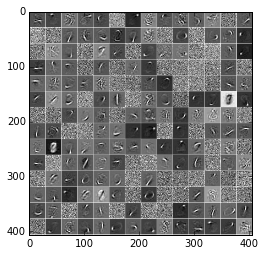

In [27]:
im = np.array(misc.visualize(params[0].get_value(), data.shape[1], fill=255))
plt.imshow(im, cmap=cm.gray)
from PIL import Image as img
img.fromarray(im).save('D.png')

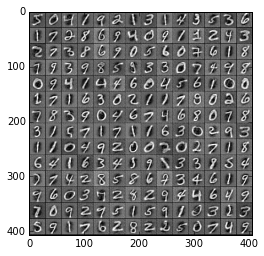

In [28]:
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = reconstructor(data[:14*14])
im = np.array(misc.visualize(recs, data.shape[1]))
plt.imshow(im, cmap=cm.gray)

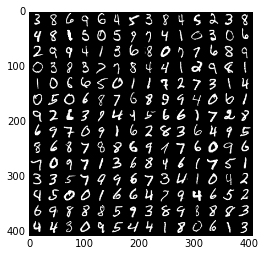

In [29]:
im = np.array(misc.visualize(valid[:14*14]+dm, 28*28))
plt.imshow(im, cmap=cm.gray)

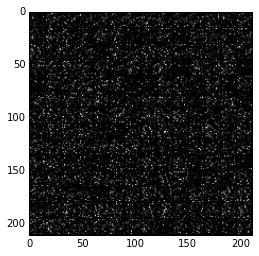

In [30]:
%matplotlib inline
# visualize latents as sparse 2d images
sparse = theano.function([x], z, allow_input_downcast=True)
sp = sparse(valid[:14*14])
im = np.array(misc.visualize(sp, sparse_shape))
plt.imshow(im, cmap=cm.gray)

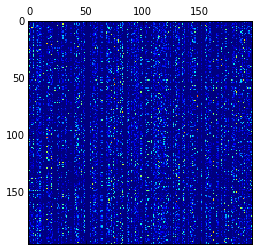

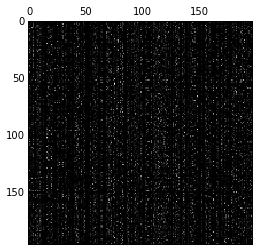

In [31]:
# if sparse code size is not a square number, use matshow
plt.matshow(sp)
# for gray values
plt.matshow(sp, cmap=cm.gray)

(array([  1.62558621e+01,   7.78935775e-01,   6.83353217e-01,
          6.13217964e-01,   5.44324043e-01,   4.55568812e-01,
          4.13363527e-01,   3.71778908e-01,   3.30194289e-01,
          2.88609669e-01,   2.56955706e-01,   2.33370399e-01,
          2.14129755e-01,   1.87441119e-01,   1.66338476e-01,
          1.42132504e-01,   1.49580495e-01,   1.30960517e-01,
          1.14823202e-01,   9.93065529e-02,   1.09237208e-01,
          9.93065529e-02,   6.88939211e-02,   8.00659083e-02,
          7.13765849e-02,   6.88939211e-02,   5.27566062e-02,
          5.95839318e-02,   5.21359403e-02,   5.39979382e-02,
          5.39979382e-02,   4.46879488e-02,   4.34466169e-02,
          4.09639531e-02,   3.84812893e-02,   4.34466169e-02,
          3.78606233e-02,   2.48266382e-02,   2.91712999e-02,
          2.66886361e-02,   2.66886361e-02,   2.60679701e-02,
          2.29646404e-02,   1.67579808e-02,   1.36546510e-02,
          2.04819765e-02,   1.92406446e-02,   1.67579808e-02,
        

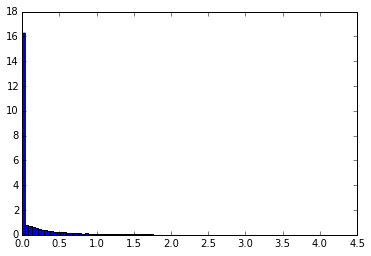

In [32]:
plt.hist(sp.ravel(), bins=100, normed=True)

In [22]:
params[1].get_value().shape

(784, 196)

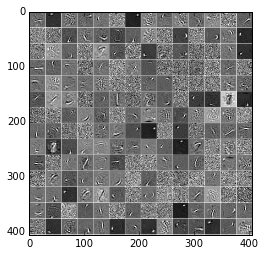

In [33]:
# in case parameters are not tied
im = np.array(misc.visualize(params[1].get_value().T, 28*28, fill=255))
plt.imshow(im, cmap=cm.gray)
from PIL import Image as img
img.fromarray(im).save('W.png')

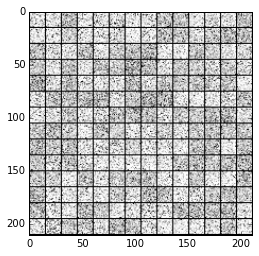

In [26]:
im = np.array(misc.visualize(params[2].get_value(), 14*14))
plt.imshow(im, cmap=cm.gray)
from PIL import Image as img
img.fromarray(im).save('Q.png')

In [27]:
params[3].get_value()

array(1.5752086639404297, dtype=float32)

In [ ]:
params[2].get_value()

In [4]:
from cifar10 import dataset as ds
data = ds.get_store("cifar10_gray_32x32.h5")
tmp = np.asarray(data['train']['inputs'], dtype=np.float)
tmp = tmp - tmp.mean(axis=1, keepdims=True)
tmp = tmp/(tmp.std(axis=1, keepdims=True) + 1e-6)
data = tmp

Loading from store cifar10_gray_32x32.h5


In [68]:
# non convolutional coders
reload(crino)
epochs = 20
btsz = 100
lr = 1
momentum = 0.1
decay = 0.95
batches = data.shape[0]/btsz
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape=14*14
Dinit = {"shape": (sparse_shape, data.shape[1]), "variant": "normal", "std": 0.1}
Qinit = {"shape": (sparse_shape, sparse_shape), "variant": "normal", "std": 0.1}
lmbd = 1 # sparsity weight
L = 1.
layers = 5
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd, "Q": Qinit}
# normalize weights according to this config
norm_dic = {"D": {"axis":1, "c": 1.}
            ,"Q": {"axis":1, "c": 1.}
            ,"W": {"axis":0, "c":1.}}
# non-diagonals should be at most 0
#thresh_dic = {"Q": {"thresh": 0}}

x, params, cost, rec, z = crino.lode(config=config, activ=T.tanh, tied=False)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "alpha": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
for p in params:
    if p.name == "Q":
        qupdt = updates[p]
        qdiag = T.diag(qupdt)
        qrest = qupdt - T.diag(qdiag)
        qdiag = T.maximum(0, qdiag)
        qdiag = 0*T.diag(qdiag)
        qrest = T.minimum(0, qrest)
        updates[p] = qdiag + qrest

updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
#updates = crino.min_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

Epochs 20
Batches per epoch 400

[LODE]
[AdaDELTA] lr: 1; decay: 0.95

INFO (theano.gof.compilelock): Refreshing lock /home/osendorf/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.10-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/osendorf/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.10-64/lock_dir/lock



[NORM_UPDT] D normalized to 1.0 along axis 1
[NORM_UPDT] W normalized to 1.0 along axis 0
[NORM_UPDT] Q normalized to 1.0 along axis 1
done.


In [101]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

0 497.201503754
1 386.516572571
2 368.231638184
3 355.991357803
4 345.983183365
5 338.437710419
6 333.937390747
7 330.634641266
8 327.418629608


KeyboardInterrupt: 

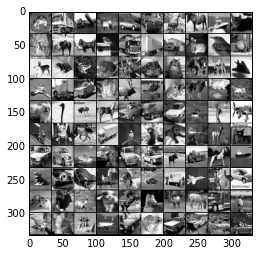

In [25]:
im = np.array(misc.visualize(tmp[:100], 32**2))
plt.imshow(im, cmap=cm.gray)

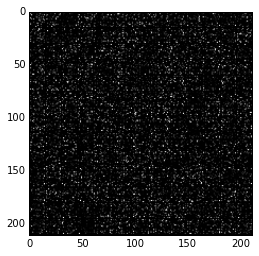

In [102]:
%matplotlib inline
# visualize latents as sparse 2d images
sparse = theano.function([x], z, allow_input_downcast=True)
sp = sparse(tmp[:14*14])
im = np.array(misc.visualize(sp, sparse_shape))
plt.imshow(im, cmap=cm.gray)

(array([  3.81408103e+00,   1.07879668e-01,   9.85045681e-02,
          9.21664725e-02,   8.79410755e-02,   8.05466307e-02,
          6.81345270e-02,   7.27560550e-02,   5.59865105e-02,
          5.66467288e-02,   5.33456374e-02,   4.92522840e-02,
          3.76324422e-02,   3.97451407e-02,   3.75003986e-02,
          2.98418665e-02,   2.78612116e-02,   2.11269851e-02,
          2.08628978e-02,   2.03347232e-02,   2.03347232e-02,
          1.49209332e-02,   1.58452388e-02,   1.10916672e-02,
          1.28082347e-02,   1.18839291e-02,   1.04314489e-02,
          1.00353179e-02,   8.84692501e-03,   6.60218285e-03,
          5.67787725e-03,   5.01765896e-03,   5.28174628e-03,
          4.35744068e-03,   4.62152799e-03,   4.35744068e-03,
          4.35744068e-03,   3.56517874e-03,   3.43313508e-03,
          3.56517874e-03,   3.82926605e-03,   3.03700411e-03,
          2.37678582e-03,   2.37678582e-03,   2.90496045e-03,
          1.05634926e-03,   1.71656754e-03,   9.24305599e-04,
        

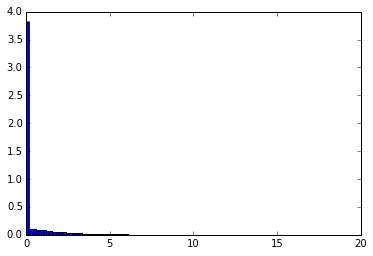

In [103]:
plt.hist(sp.ravel(), bins=100, normed=True)

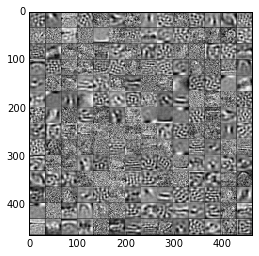

In [109]:
# in case parameters are not tied
im = np.array(misc.visualize(params[1].get_value().T, 32*32))
plt.imshow(im, cmap=cm.gray)
from PIL import Image as img
img.fromarray(im).save('Wcifar.png')

In [105]:
data = tmp

In [106]:
data.shape

(40000, 1024)

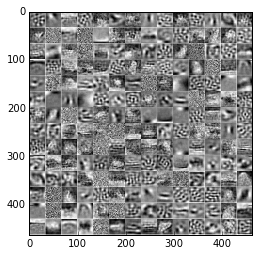

In [108]:
im = np.array(misc.visualize(params[0].get_value(), data.shape[1], fill=255))
plt.imshow(im, cmap=cm.gray)
from PIL import Image as img
img.fromarray(im).save('D.png')

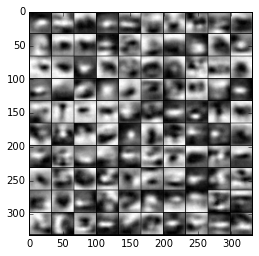

In [91]:
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = reconstructor(data[:100])
im = np.array(misc.visualize(recs, data.shape[1]))
plt.imshow(im, cmap=cm.gray)

In [ ]:
# convolutional coders
reload(crino)
epochs = 20
btsz = 100
lr = 1
momentum = 0.1
decay = 0.95
batches = data.shape[0]/btsz
print "Epochs", epochs
print "Batches per epoch", batches
print

sparse_shape = 40
Dinit = {"shape": (1, sparse_shape, 15, 15), "variant": "uniform", "std": 0.1}
Qinit = {"shape": (sparse_shape, sparse_shape, 1, 1), "variant": "normal", "std": 0.1}
Winit = {"shape": (sparse_shape, 1, 15, 15), "variant": "uniform", "std": 0.1}
imshape = (btsz, 1, 28, 28)
lmbd = 0.00001 # sparsity weight
L = 1
layers = 10
config = {"D": Dinit, "layers": layers, "L": L, "lambda": lmbd, "Q": Qinit, "W": Winit,
          "imshape": imshape}
# normalize weights according to this config
norm_dic = {"D": {"axis": (2,3), "c": 1.}
            ,"Q": {"axis":(1, 2, 3), "c": 1.}
            ,"W": {"axis": (2,3), "c":1.}}
# non-diagonals should be at most 0
#thresh_dic = {"Q": {"thresh": 0}}

x, params, cost, rec, z = crino.lodeconv(config=config, activ=T.tanh, tied=False)
grads = T.grad(cost, params)

# training ...
settings = {"lr": lr, "momentum": momentum, "decay": decay}
# ... with stochastic gradient + momentum
#updates = crino.momntm(params, grads, settings)#, **norm_dic)
updates = crino.adadelta(params, grads, settings)#, **norm_dic)
# ... normalize weights
for p in params:
    if p.name == "Q":
        qupdt = updates[p]
        qupdt = qupdt.flatten(ndim=2)
        qdiag = T.diag(qupdt)
        qrest = qupdt - T.diag(qdiag)
        qdiag = T.diag(T.maximum(0, qdiag))
        #qdiag = 0.*T.diag(qdiag)
        qrest = T.minimum(0, qrest)
        qupdt = qdiag + qrest
        qupdt = qupdt.reshape(updates[p].shape)
        updates[p] = qupdt

updates = crino.norm_updt(params, updates, todo=norm_dic)
# ... make sure threshold is big enough
#updates = crino.min_updt(params, updates, todo=thresh_dic)

train = theano.function([x], cost, updates=updates, 
                        allow_input_downcast=True)
print 'done.'

In [ ]:
# Rerun this cell if another full number of epochs should be trained.
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz].reshape(100, 1, 28, 28))
    print epoch, cost/sz

In [ ]:
reconstructor = theano.function([x], rec, allow_input_downcast=True)
recs = reconstructor(data[:10*10].reshape(100, 1, 28, 28))
im = np.array(misc.visualize(recs, data.shape[1], fill=255))
plt.imshow(im, cmap=cm.gray)

In [ ]:
((params[-1].get_value()))

In [ ]:
im = np.array(misc.visualize(params[0].get_value().reshape(40, 225), 225, fill=255))
plt.imshow(im, cmap=cm.gray)
import Image as img
img.fromarray(im).save('D.png')

In [ ]:
params[1].get_value()